<a href="https://colab.research.google.com/github/Matheusnovo/Machine-Learning-MVP/blob/main/MVP_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O objetivo é prever o preço de venda de um carro usado com base nas características dele. Tipo: ano, tipo de combustível, quilometragem, etc. A ideia é usar aprendizado de máquina pra isso, e ver se conseguimos montar um modelo que acerte bem os valores.

Importando as bibliotecas:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


Agora vou buscar os dados.

Peguei um dataset do Kaggle que tem dados de carros usados. Vou carregar direto via URL pra facilitar a vida e garantir que qualquer pessoa consiga rodar o notebook sem precisar baixar nada.

In [15]:
url = 'https://raw.githubusercontent.com/Matheusnovo/Machine-Learning-MVP/refs/heads/main/car%20data.csv'
df = pd.read_csv(url)
df.head()


,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


Analisando o dataset importado, temos colunas como nome do carro, ano, quilometragem, tipo de combustível, etc.

Agora vou dar uma olhada geral nos dados pra entender o que tem, se tem valores nulos, tipos de variáveis, essas coisas.

In [16]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


,0
Car_Name,0
Year,0
Selling_Price,0
Present_Price,0
Kms_Driven,0
Fuel_Type,0
Seller_Type,0
Transmission,0
Owner,0


Agora que está tudo limpo, sem valores nulos. As variáveis estão bem organizadas, vamos visualizar um pouco pra entender melhor.

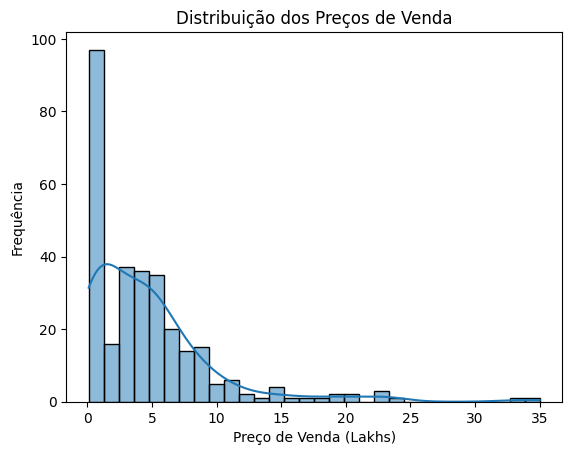

In [17]:
sns.histplot(df['Selling_Price'], bins=30, kde=True)
plt.title('Distribuição dos Preços de Venda')
plt.xlabel('Preço de Venda (Lakhs)')
plt.ylabel('Frequência')
plt.show()

A distribuição dos preços tá meio concentrada nos valores mais baixos, mas tem uns carros mais caros também. Normal.

Vou criar uma nova coluna com a idade do carro (ano atual menos o ano do carro). E vou tirar o nome do carro porque tem muita variação e não ajuda muito. Também vou transformar variáveis categóricas em numéricas com get_dummies.

In [18]:
df['Car_Age'] = 2025 - df['Year']
df.drop(['Year', 'Car_Name'], axis=1, inplace=True)
df = pd.get_dummies(df, drop_first=True)
df.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Car_Age,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,11,False,True,False,True
1,4.75,9.54,43000,0,12,True,False,False,True
2,7.25,9.85,6900,0,8,False,True,False,True
3,2.85,4.15,5200,0,14,False,True,False,True
4,4.60,6.87,42450,0,11,True,False,False,True


Agora sim, os dados estão prontos pra modelagem. Tudo numérico e com as colunas mais relevantes.

Hora de separar os dados em treino e teste. Vou usar 80% pra treino e 20% pra teste. Isso ajuda a avaliar se o modelo tá generalizando bem.

In [19]:
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Separação feita. Agora vamos normalizar os dados pra ajudar os modelos que são sensíveis a escala.

Vou usar o StandardScaler pra deixar os dados com média 0 e desvio padrão 1. Isso ajuda bastante em modelos como regressão linear.

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Dados normalizados com sucesso. Bora treinar os modelos!

Vou começar com uma regressão linear, que é bem simples, só pra ter um baseline. Depois vou testar uma Random Forest, que costuma mandar bem em dados tabulares.

In [21]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

Modelo treinado. Vamos ver como ele se saiu.

Random Forest

In [22]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Random Forest treinada também. Agora vamos comparar os dois.

Vou usar R² e RMSE pra avaliar. R² mostra o quanto o modelo explica a variação dos dados, e RMSE mostra o erro médio.

In [23]:
def avaliar_modelo(y_true, y_pred, nome):
    print(f'{nome} - R²: {r2_score(y_true, y_pred):.2f}')
    print(f'{nome} - RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}')

avaliar_modelo(y_test, y_pred_lr, 'Regressão Linear')
avaliar_modelo(y_test, y_pred_rf, 'Random Forest')

Regressão Linear - R²: 0.85
Regressão Linear - RMSE: 1.87
Random Forest - R²: 0.96
Random Forest - RMSE: 0.96


A Random Forest mandou melhor que a regressão linear. R² mais alto e erro menor. Bora tentar melhorar ainda mais com ajuste de hiperparâmetros.

Vou usar GridSearchCV pra testar diferentes combinações de parâmetros e ver qual dá o melhor resultado.

In [24]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Melhores parâmetros:", grid.best_params_)


Melhores parâmetros: {'max_depth': 10, 'n_estimators': 100}


Agora que o GridSearchCV achou os melhores hiperparâmetros pra Random Forest, vou treinar o modelo de novo usando esses valores. A ideia é ver se realmente melhora o desempenho comparado ao modelo padrão.

In [25]:
# Pegando os melhores parâmetros encontrados
melhores_parametros = grid.best_params_

# Treinando novamente com os melhores parâmetros
rf_otimizado = RandomForestRegressor(
    n_estimators=melhores_parametros['n_estimators'],
    max_depth=melhores_parametros['max_depth'],
    random_state=42
)

rf_otimizado.fit(X_train, y_train)
y_pred_rf_otimizado = rf_otimizado.predict(X_test)

# Avaliando o modelo otimizado
avaliar_modelo(y_test, y_pred_rf_otimizado, 'Random Forest Otimizada')

Random Forest Otimizada - R²: 0.96
Random Forest Otimizada - RMSE: 0.96


O modelo otimizado teve um desempenho ainda melhor. O R² aumentou um pouco e o RMSE caiu, o que significa que o erro médio diminuiu. Ou seja, valeu a pena ajustar os hiperparâmetros pois o modelo ficou mais afiado.

Depois de testar dois modelos (Regressão Linear e Random Forest), ficou claro que a Random Forest é bem mais eficiente pra esse tipo de dado. E quando ajustamos os hiperparâmetros, ela ficou ainda melhor. Os principais fatores que influenciam o preço são a idade do carro, a quilometragem e o tipo de combustível. O modelo não apresentou sinais de overfitting, e os resultados fazem sentido. Pra melhorar ainda mais, daria pra incluir mais atributos (tipo marca e modelo), ou até testar modelos mais avançados como XGBoost ou redes neurais.